# Generate Fake Data

In this file, I create randomized signals and labels to see if the channel flipping 'signature' is sufficient information for the model to train even when all the data and labels are fake.

In [ ]:
# import necessary libraries
import numpy as np
import random
import matplotlib.pyplot as plt

Psuedo code for fake signal generation

For all subjects (103) and trials (15*3)

Generate data for one channel for 640 reps

Generate surrounding channels by adding noise to that channel

Randomly flip some channels

Assign random category

Chunk into 8 sections

In [ ]:
# generate fake data to test effect of flipping some channels

# set constant
nChan = 64
nSubj = 103
nTrialsPerSubj = 45
trialLen = 640
nSubset = 8
subLen = int(trialLen / nSubset)

# initialize data variables
dataset_x = np.zeros((nSubj*nTrialsPerSubj*nSubset, nChan, subLen))
dataset_y = np.zeros((nSubj*nTrialsPerSubj*nSubset, 2))
count = 0

for iTrial in range(nSubj*nTrialsPerSubj):
  # generate random signal for all channels
  signal = np.zeros((nChan, trialLen));
  signal[0,:] = [x - 0.5 for x in [random.random() for _ in range(trialLen)]]
  for iChan in range(1,64):
    signal[iChan,:] = signal[iChan-1,:] + [0.3*(x-0.5) for x in[random.random() for _ in range(trialLen)]]
  # flip some channels with probability 0.5 (set to 0 if interested in non-flipped data)
  for iChan in range(64):
    if random.random() < 0.5:
      signal[iChan,:] *= -1
  # pick random label for this trial
  label = random.randint(0,1)
  # segment signal into 8 pieces and add to dataset_x
  for iSubSeg in range(nSubset):
    segment = signal[:, iSubSeg*subLen:(iSubSeg+1)*subLen]
    dataset_x[count, :, :] = segment
    dataset_y[count, label] = 1
    count += 1





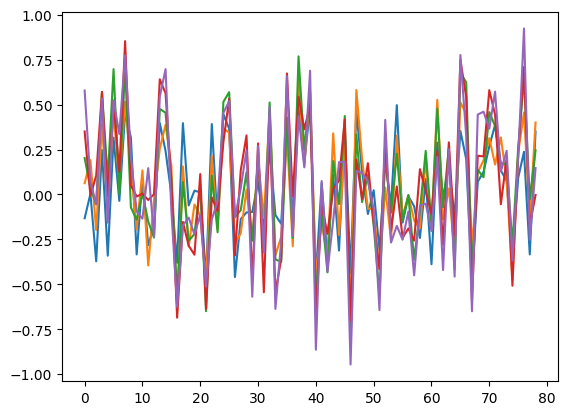

In [ ]:
# visualizing signal to see if noise is sufficient
for iChan in range(5):
  plt.plot(signal[iChan,1:80])

In [ ]:
# select samples for train/validation set
nTrials = 360*103
train_idx = random.sample(list(range(nTrials)), int(nTrials*0.8))

In [ ]:
# create train set
x_train = dataset_x[train_idx, :,:]
y_train = dataset_y[train_idx,:]

In [ ]:
# reshape x to fit as input to network
x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1], x_train.shape[2])

# Train Fake Data

In [ ]:
import keras
from keras import layers
from keras import ops

keras.backend.set_image_data_format('channels_first')

In [ ]:
# Create fusionNet as explained in original paper

nChans = 64

#build first branch of model
axVal = 1
input_shape = (1, 64, 80)

input1 = keras.Input(shape=(input_shape))
branch1 = keras.layers.Conv2D(4, (1, 64), padding='same', use_bias=False, input_shape=input_shape)(input1)
branch1 = keras.layers.BatchNormalization(axis=axVal)(branch1)
branch1 = keras.layers.DepthwiseConv2D((64,1), depth_multiplier=2, depthwise_constraint=keras.constraints.max_norm(1.), use_bias=False)(branch1)
branch1 = keras.layers.BatchNormalization(axis=axVal)(branch1)
branch1 = keras.layers.Activation('elu')(branch1)
branch1 = keras.layers.AveragePooling2D((1,4))(branch1)
branch1 = keras.layers.Dropout(0.5)(branch1)
branch1 = keras.layers.SeparableConv2D(16, (1,8), padding='same', use_bias=False)(branch1)
branch1 = keras.layers.BatchNormalization(axis=axVal)(branch1)
branch1 = keras.layers.Activation('elu')(branch1)
branch1 = keras.layers.AveragePooling2D((1,8))(branch1)
branch1 = keras.layers.Dropout(0.5)(branch1)
branch1 = keras.layers.Flatten()(branch1)

# second branch
input2 = keras.Input(shape=(input_shape))
branch2 = keras.layers.Conv2D(8, (1, 128), padding='same', use_bias=False, input_shape=input_shape)(input2)
branch2 = keras.layers.BatchNormalization(axis=axVal)(branch2)
branch2 = keras.layers.DepthwiseConv2D((64,1), depth_multiplier=2, depthwise_constraint=keras.constraints.max_norm(1.), use_bias=False)(branch2)
branch2 = keras.layers.BatchNormalization(axis=axVal)(branch2)
branch2 = keras.layers.Activation('elu')(branch2)
branch2 = keras.layers.AveragePooling2D((1,4))(branch2)
branch2 = keras.layers.Dropout(0.5)(branch2)
branch2 = keras.layers.SeparableConv2D(16, (1,16), padding='same', use_bias=False)(branch2)
branch2 = keras.layers.BatchNormalization(axis=axVal)(branch2)
branch2 = keras.layers.Activation('elu')(branch2)
branch2 = keras.layers.AveragePooling2D((1,8))(branch2)
branch2 = keras.layers.Dropout(0.5)(branch2)
branch2 = keras.layers.Flatten()(branch2)

# third branch
input3 = keras.Input(shape=(input_shape))
branch3 = keras.layers.Conv2D(16, (1, 256), padding='same', use_bias=False, input_shape=input_shape)(input3)
branch3 = keras.layers.BatchNormalization(axis=axVal)(branch3)
branch3 = keras.layers.DepthwiseConv2D((64,1), depth_multiplier=2, depthwise_constraint=keras.constraints.max_norm(1.), use_bias=False)(branch3)
branch3 = keras.layers.BatchNormalization(axis=axVal)(branch3)
branch3 = keras.layers.Activation('elu')(branch3)
branch3 = keras.layers.AveragePooling2D((1,4))(branch3)
branch3 = keras.layers.Dropout(0.5)(branch3)
branch3 = keras.layers.SeparableConv2D(16, (1,32), padding='same', use_bias=False)(branch3)
branch3 = keras.layers.BatchNormalization(axis=axVal)(branch3)
branch3 = keras.layers.Activation('elu')(branch3)
branch3 = keras.layers.AveragePooling2D((1,8))(branch3)
branch3 = keras.layers.Dropout(0.5)(branch3)
branch3 = keras.layers.Flatten()(branch3)

merge1 = keras.layers.concatenate([branch1, branch2])
merge2 = keras.layers.concatenate([merge1, branch3])

flat = keras.layers.Flatten()(merge2)

dense1 = keras.layers.Dense(2, kernel_constraint=keras.constraints.max_norm(0.25))(flat)

mod_out = keras.layers.Softmax()(dense1)

model = keras.Model(inputs=[input1, input2, input3], outputs=mod_out)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# callbacks to adjust learning rate or do early stopping val_loss stops improving

callback_list = [keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1), keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=False,
    start_from_epoch=10
)]

In [ ]:
# see model and compile
model.summary()
model.compile(loss = keras.losses.binary_crossentropy,optimizer= keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 1, 64, 80)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 1, 64, 80)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 4, 64, 80)      │            256 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 8, 64, 80)      │          1,024 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 1, 64, 80)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 4, 64, 80)      │             16 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 8, 64, 80)      │             32 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 16, 64, 80)     │          4,096 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ depthwise_conv2d          │ (None, 8, 1, 80)       │            512 │ batch_normalization[0… │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ depthwise_conv2d_1        │ (None, 16, 1, 80)      │          1,024 │ batch_normalization_3… │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 16, 64, 80)     │             64 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 8, 1, 80)       │             32 │ depthwise_conv2d[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 16, 1, 80)      │             64 │ depthwise_conv2d_1[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ depthwise_conv2d_2        │ (None, 32, 1, 80)      │          2,048 │ batch_normalization_6… │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activatio

 Total params: 11,922 (46.57 KB)

 Trainable params: 11,658 (45.54 KB)

 Non-trainable params: 264 (1.03 KB)

In [ ]:
# train!
hist = model.fit([x_train, x_train, x_train], y_train, batch_size=64, shuffle=True, epochs=50, validation_split=0.125, callbacks=callback_list)

Epoch 1/50
406/406 ━━━━━━━━━━━━━━━━━━━━ 51s 82ms/step - accuracy: 0.5133 - loss: 0.6934 - val_accuracy: 0.5734 - val_loss: 0.6789 - learning_rate: 0.0010
Epoch 2/50
406/406 ━━━━━━━━━━━━━━━━━━━━ 55s 44ms/step - accuracy: 0.6027 - loss: 0.6624 - val_accuracy: 0.6634 - val_loss: 0.6199 - learning_rate: 0.0010
Epoch 3/50
406/406 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.6822 - loss: 0.6015 - val_accuracy: 0.7104 - val_loss: 0.5738 - learning_rate: 0.0010
Epoch 4/50
406/406 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - accuracy: 0.7116 - loss: 0.5675 - val_accuracy: 0.7265 - val_loss: 0.5445 - learning_rate: 0.0010
Epoch 5/50
406/406 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - accuracy: 0.7338 - loss: 0.5394 - val_accuracy: 0.7406 - val_loss: 0.5250 - learning_rate: 0.0010
Epoch 6/50
406/406 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - accuracy: 0.7451 - loss: 0.5222 - val_accuracy: 0.7495 - val_loss: 0.5095 - learning_rate: 0.0010
Epoch 7/50
406/406 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - accuracy: 0.7741 - l

In [ ]:
# create test set

nTrials = 360*103
test_idx = list(range(nTrials))

for idx in train_idx:
  test_idx.remove(idx)

x_test = dataset_x[test_idx, :,:]
y_test = dataset_y[test_idx,:]

x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1], x_test.shape[2])

In [ ]:
# get test accuracy
model.evaluate([x_test,x_test,x_test], y_test)

232/232 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8971 - loss: 0.2738


[0.2646249830722809, 0.8998112082481384]

In [ ]:
# save history
np.save('/content/drive/MyDrive/DL Final/FusionWithFlipFake.npy',hist.history)